In [1]:
import cusfbamboo as bam
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI
import cantera as ct

In [2]:
'''Chosen operating points'''
# O/F = 10.2
pc = 2.7579e6           # Chamber pressure (Pa)
_pc = 2.7579e6

'''From ProPEP 3 I got the following data on my exhaust gas'''
gamma = 1.24               # Ratio of specific heats cp/cv 
molecular_weight = 26.24   # Molecular weight of the exhaust gas (kg/kmol) 
Tc = 3281.188          # Chamber temperature (K)

In [3]:
perfect_gas = bam.PerfectGas(gamma = gamma, molecular_weight = molecular_weight)
chamber_conditions = bam.ChamberConditions(p0 = pc, T0 = Tc)

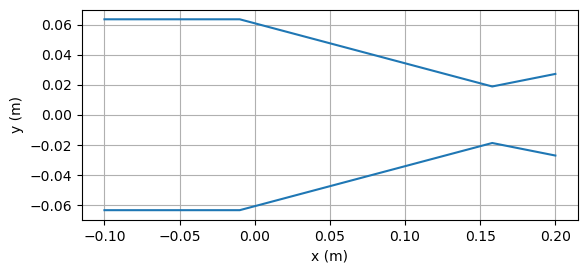

Sea level thrust = 4.279528730516076 kN
Sea level Isp = 221.3639201012726 s

Throat pressure = 15.356257916295181 bar
Throat temperature = 2929.6321428571428 K
Throat Mach number = 1.0

Exit pressure = 2.958391925507764 bar
Exit temperature = 2130.009493728882 K
Exit Mach number = 2.1222177545315266
1.9706981183173924


In [4]:
xs = [-0.1, -0.08, -0.025, -0.01, 0.158, 0.2]         # The values in 'xs' must be in increasing order
rs = [0.127/2, 0.127/2, 0.127/2, 0.127/2, 0.0376/2, 0.02715]
geometry = bam.Geometry(xs = xs, rs = rs)

engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry)
engine.plot()
bam.show()

print(f"Sea level thrust = {engine.thrust(p_amb = 1e5)/1000} kN")
print(f"Sea level Isp = {engine.isp(p_amb = 1e5)/9.81} s")

print(f"\nThroat pressure = {engine.p(x = geometry.x_t)/1e5} bar")
print(f"Throat temperature = {engine.T(x = geometry.x_t)} K")
print(f"Throat Mach number = {engine.M(x = geometry.x_t)}")

print(f"\nExit pressure = {engine.p(xs[-1])/1e5} bar")
print(f"Exit temperature = {engine.T(xs[-1])} K")
print(f"Exit Mach number = {engine.M(xs[-1])}")

print(engine.mdot)

In [5]:
gas = ct.Solution('gri30.yaml')
# We set up an exhaust gas model using Cantera - using the exhaust gas properties we found before
# Then we set up the coolant transport properties with CoolProp

# Setup the exhaust gas transport properties using Cantera
def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity # Definition of Prandtl number (from bamboo Cantera example)

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity

def k_exhaust(T, p):
    gas.TP = T, p
    return gas.thermal_conductivity

exhaust_transport = bam.TransportProperties(Pr = Pr_exhaust,
                                            mu = mu_exhaust,
                                            k = k_exhaust)

# Set up the coolant transport properties using Cantera
# defining coolant:
coolant = ct.Solution('gri30.yaml')
gas.TPY = 298.15, _pc, "N2O:1" # defining starting conditions for coolant to be at chamber pressure and standard ambient temperature

P = 5.24e6

coolant_name = "NITROUSOXIDE"
def Pr_coolant(T, p):
    coolant.TP = T, p
    return PropsSI('PRANDTL','P', P,'Q',0, 'WATER')

def mu_coolant(T, p):
    coolant.TP = T, p
    return PropsSI('V','P', P,'Q',0, coolant_name)

def k_coolant(T, p):
    coolant.TP = T, p
    return PropsSI('L','P', P,'Q',0, coolant_name)

def cp_coolant(T, p):
    coolant.TP = T, p
    return PropsSI('C','P', P,'Q',0, coolant_name)

def rho_coolant(T, p):
    coolant.TP = T, p
    return PropsSI('D','P', P,'Q',0, coolant_name)

k = 17.4
cp = PropsSI('C','P', P,'Q',0, coolant_name)
mu = 3.237e-3

coolant_transport = bam.TransportProperties(Pr = (cp * mu)/k,
                                            mu = 3.237e-03,
                                            k = k,
                                            cp = PropsSI('C','P', P,'Q',0, coolant_name),
                                            rho = PropsSI('D','P', P,'Q',0, coolant_name))

# Note: when using CoolProp for coolant trasnport properties, get following error
# ValueError: Viscosity model is not available for this fluid : 
# PropsSI("PRANDTL","T",298.15,"P",2758000,"NITROUSOXIDE")
# so using Cantera instead

'''Cooling jacket properties'''
inlet_T = 298.15                           # Coolant inlet static temperature (K)
inlet_p = 5.171e6                             # Coolant inlet static pressure (bar)
OF_ratio = 10.2                           # Oxidiser/fuel mass ratio
mdot_coolant = 1.633  # Mass flow rate of coolant

x = np.linspace(5e-4, 10e-3, 10)
y = np.linspace(5e-4, 10e-3, 10)

'''Add a spiral cooling jacket to the engine'''
# See the documentation for a full list of cooling jacket options

cooling_jacket = bam.CoolingJacket(T_coolant_in = inlet_T, 
                                  p_coolant_in = inlet_p, 
                                  mdot_coolant = mdot_coolant, 
                                  channel_height = 1e-3,
                                  channel_width = 1e-3,
                                  coolant_transport = coolant_transport,
                                  configuration = 'vertical')

In [6]:
copper = bam.Material(E = 117e9, poisson = 0.34, alpha = 16.9e-6, k = 391.2)
stainless_steel = bam.Material(E = 193e9, poisson = 0.29, alpha = 16e-6, k = 14.0)

def variable_thickness(x):
    fraction = (x - xs[0]) / (xs[-1] - xs[0])
    return 4e-3 * (1 - fraction) + 1e-3

inner_wall = bam.Wall(material = copper, thickness = 5e-3)
#outer_wall = bam.Wall(material = copper, thickness = 2e-3)   # Thickness that decreases with increasing x

/Users/ryansmithers/anaconda3/envs/Project_Liquid/lib/python3.11/site-packages/cusfbamboo/hx.py:84: UserWarning: ReDh < 3500 in cooling channels: Flow is in between the laminar and turbulent regions - blending will be used. Constant wall temperature is assumed for laminar Nusselt number.
  R = self.Rdx(self.state[i]))


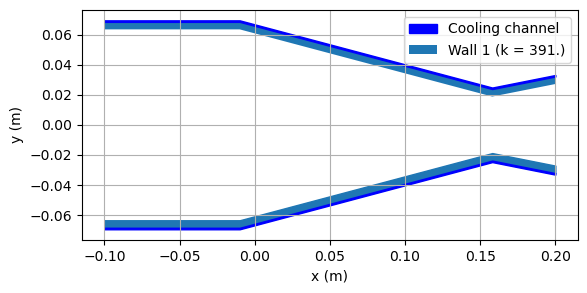

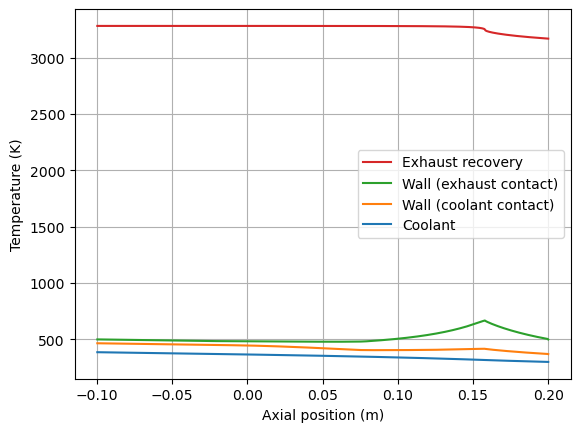


Coolant exit temperature: 384.4192880343588 K

dict_keys(['info', 'x', 'T', 'T_coolant', 'T_exhaust', 'dQ_dx', 'dQ_dLc', 'dQ_dA', 'Rdx', 'p_coolant', 'rho_coolant', 'V_coolant', 'Dh_coolant', 'sigma_t_thermal', 'sigma_t_pressure', 'sigma_t_max', 'r'])

Information on the 'T' key:
Static temperature at each position (K). T[i][j], is the temperature at x[i], at the j'th wall boundary. j = 0 corresponds to the coolant, j = -1 corresponds to the exhaust gas.


In [7]:
            engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    exhaust_transport = exhaust_transport,
                    cooling_jacket = cooling_jacket,
                    walls = [inner_wall],
                    coolant_convection = "gnielinski",
                    exhaust_convection = "bartz-sigma")
    
            cooling_data = engine.steady_heating_analysis()
            engine.plot()
            bam.plot.plot_temperatures(cooling_data)
            bam.show()
            print(f"\nCoolant exit temperature: {cooling_data['T_coolant'][-1]} K")
            # Print of the keys so we can see what data is available
            print("")
            print(cooling_data.keys())

# We can get information on what each key means, with the 'info' key.
            print("\nInformation on the 'T' key:")
            print(cooling_data["info"]["T"])

In [8]:
# Chamber conditions
_pc = 2.758e+6                # Chamber pressure (Pa)
thrust = 4448.22             # Desired thrust (N)
p_amb = 101325               # Ambient pressure (Pa) - sea level pressure
OF = 10.25                   # OF mass ratio

# We define our gas mixture via propellant initial temperature, pressure, mass ratio
gas = ct.Solution('gri30.yaml')
gas.TPY = 300, _pc, "C2H6:1, N2O:10.25"   # Very approximate fuel/ox inlet temperature
# Solution properties before chemical equilibrium
# gas()

In [9]:
# OF ratio:
OF = range(20)[2:] 
P = 2.758e+6 # 400 PSI
T = list()

# populate T list:
for of in OF: 
    gas = ct.Solution('gri30.yaml')
    mixture = "C2H6:1, N2O:{}".format(of)
    gas.TPY = 384.419, _pc, mixture
    gas.equilibrate("HP") # Equilibrate keeping enthalpy and pressure constant 
    T.append(gas.T) # add chamber temperature

[1523.0691501311846, 1764.08659609608, 2381.872653187806, 2809.854649743156, 3087.3940960560567, 3240.538027688513, 3303.276867356191, 3315.988835870966, 3304.598804152439, 3281.7171651311633, 3253.288035684634, 3222.2552304354153, 3190.168980365396, 3157.8912204828675, 3125.922108563158, 3094.5605366635837, 3063.9875503411927, 3034.311925882183]


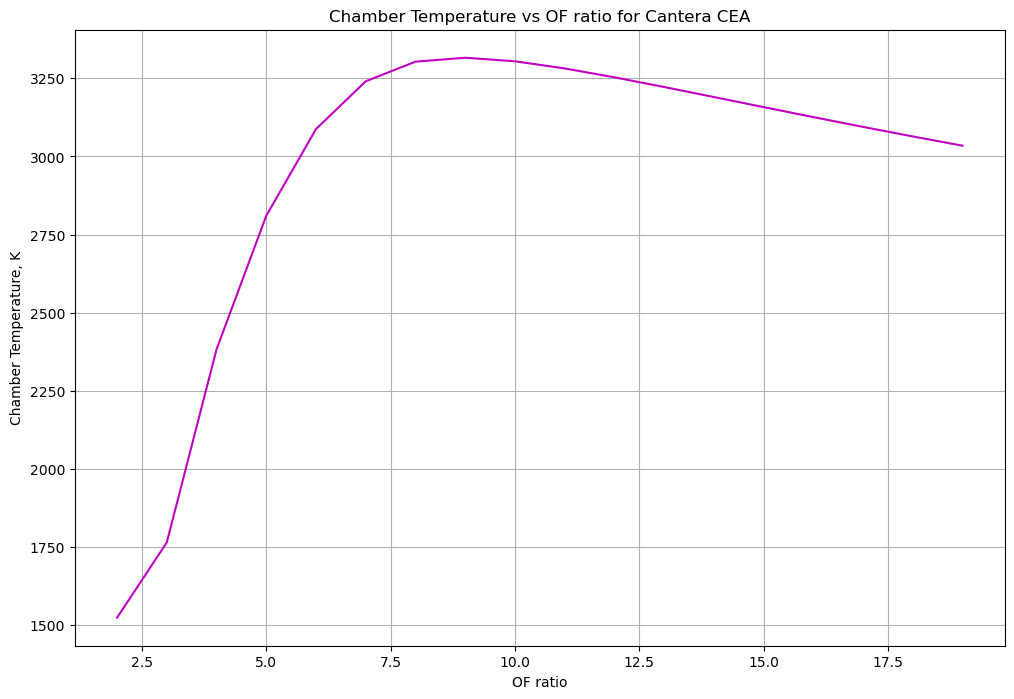

In [10]:
print(T)
import os
import matplotlib.pyplot as plt
folder = "canteraplots/"
if not os.path.exists(folder):
        os.mkdir(folder)

# Plot results
fig, ax = plt.subplots(figsize=(12,8))
plt.grid()
plt.plot(OF, T, color="m")
ax.set_ylabel("Chamber Temperature, K")
ax.set_xlabel("OF ratio")
plt.title("Chamber Temperature vs OF ratio for Cantera CEA")
plt.savefig(folder + "TvsOF.png", dpi=300)

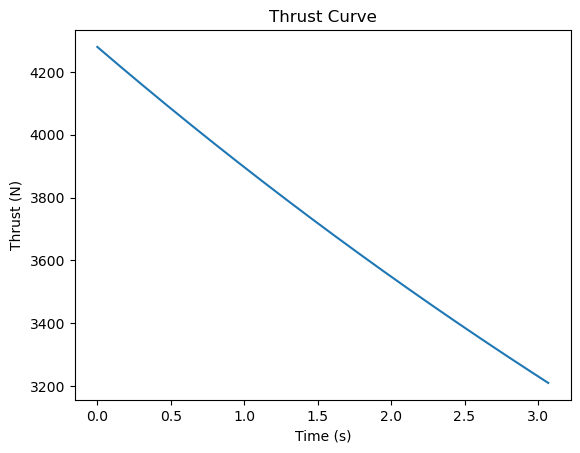

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# Assuming engine.thrust(p_amb = 1e5)/1000 is defined elsewhere and gives the initial thrust
th = (engine.thrust(p_amb = 1e5) / 1000)*1000
t = np.linspace(0, 3.07, 1000)

def exponential_decrease(initial_value, t, Time):
    k = -np.log(0.75) / Time
    return initial_value * np.exp(-k * t)

# Generate thrust values
Time = 3.07
thrust_values = [exponential_decrease(th, time_step, Time) for time_step in t]

# Plotting
plt.plot(t, thrust_values)
plt.title("Thrust Curve")
plt.xlabel("Time (s)")
plt.ylabel("Thrust (N)")
plt.show()

# Save to CSV
with open('./Data/ThrustCurve.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for time_step, thrust in zip(t, thrust_values):
        writer.writerow([time_step, thrust])

# Note: The file ThrustCurve.csv is saved in the current working directory of the Python script.
# To save it to your Downloads folder, provide the full path like '/path/to/Downloads/ThrustCurve.csv' in open().